Inference Script

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch.nn as nn
import torch
import segmentation_models_pytorch as sm
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
import tifffile
from sklearn.model_selection import KFold
import glob
import tqdm as tqdm
import utils
from typing import Tuple, Dict
import cv2
import torch.nn.functional as F




In [3]:
#Defining configurations
class Configuration:
    MODEL_SAVEPATH = "models/"
    ENCODER = "efficientnet-b2"#"se_resnext101_32x4d"#"se_resnext50_32x4d"
    DEVICE = "cuda" if torch.cuda.is_available() else cpu
    PRETRAINED_WEIGHTS = "imagenet"
    INPUT_CHANNELS = 3
    CLASSES = 2
    PREPROCESS = sm.encoders.get_preprocessing_fn(ENCODER,PRETRAINED_WEIGHTS)
    

cfg = Configuration()  

In [4]:
def pad_image(image:np.ndarray,pad_for_stride:Tuple = (512,512))->np.ndarray:
    padded_imag = np.ones((int(np.ceil(image.shape[0]/pad_for_stride[0])*pad_for_stride[0]),int(np.ceil(image.shape[1]/pad_for_stride[1])*pad_for_stride[1]),3),np.uint8)
    padded_imag.fill(255)
    for col in range(image.shape[1]):
        padded_imag[:,col,:][0:image.shape[0]] = image[:,col,:][:]
        
    return padded_imag



def unpad_image(image:np.ndarray,original_dim:Tuple = (4536,4704))->np.ndarray:
    return image[0:original_dim[0],0:original_dim[1]]




def tile_generator(image:np.ndarray,tile_size:Tuple = (512,512))->list:
    cx,cy = 0,0
    max_height = image.shape[0]
    max_width = image.shape[1]
    tile = []
    while cy+tile_size[0] <= max_height: 
        width_wise_tiles = []
        while cx+tile_size[1] <= max_width:
            width_wise_tiles.append(image[cy:cy+tile_size[0],cx:cx+tile_size[1]])  
            cx+=tile_size[1]
        cy+=tile_size[0]
        cx=0
        tile.append(width_wise_tiles)
    return tile




def pred_mask(model:torch.nn,tiles:np.ndarray,mask_shape:Tuple,save_mask = True)->np.ndarray:
    model.eval()
    predicted_masks_of_all_patches = []
    patches_collected = []
    mask_acc = np.zeros((mask_shape))
    row = 0
    column = 0
    for i in range(tiles.shape[0]):
        
        
        for j in range(tiles.shape[1]):
            
            prep = preprocess(image = tiles[i,j])['image']
            prep = prep.unsqueeze(0)
            p = torch.softmax(model(prep.to(cfg.DEVICE).float()),1)
            predicted_mask = p[0][1].detach().cpu().numpy()>0.5
            
            if save_mask:
                patches_collected.append(tiles[i,j])
                predicted_masks_of_all_patches.append(predicted_mask)
            mask_acc[row:row+512,column:column+512] = predicted_mask
            
            column+=512
            
        row+=512
        column=0
            
            
    return mask_acc,patches_collected,predicted_masks_of_all_patches if save_mask else mask_acc
    
            
            
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)
        
    
def dice_score(pred, truth, eps=1e-8):
    pred = pred.reshape(-1) > 0
    truth = truth.reshape(-1) > 0
    intersect = (pred & truth).sum(-1)
    union = pred.sum(-1) + truth.sum(-1)

    dice = (2.0 * intersect + eps) / (union + eps)
    return dice
  
    
def save_masks_(image_id:str,mask_list:list,original_patches:list)->None:
    
    if not os.path.isdir("result_patches/"+image_id):
        os.makedirs("result_patches/"+image_id)
    
    path = "result_patches/"+image_id+"/"
    for i,tile_mask in enumerate(mask_list):
        tile_mask = cv2.cvtColor(np.uint8(tile_mask*255),cv2.COLOR_GRAY2RGB)
        concat_image_mask = cv2.hconcat([np.uint8(original_patches[i]),tile_mask])
        io.imsave(path+image_id+f"_{i}.png",concat_image_mask)
        # io.imsave(path+image_id+f"image_{i}.png",tile_mask)
        
        
    
def prediction(model:torch.nn,data_path:str,dataframe:pd.DataFrame,save_masks:bool=True):
    dice = []
    submission = pd.DataFrame(columns=["id","predictions"])
    for i,row in enumerate(dataframe.iloc[:,0]):
        img_path = data_path+"/test/"+row+".tiff"
        mask_path = data_path+"/test_mask/"+row+".tiff"
        print("testing",row)
        imag = tifffile.imread(img_path)
        mask = tifffile.imread(mask_path)
        padded_image = pad_image(imag)
        tiles = np.array(tile_generator(padded_image))
        
        result = pred_mask(model,tiles,padded_image.shape[0:-1],save_mask=save_masks)
        if save_masks:
            save_masks_(row,result[2],result[1])
            
            result = result[0]
        result = unpad_image(result[0],(imag.shape[0],imag.shape[1],1))
        plt.imshow(result)
        plt.show()
        rle = rle_encode_less_memory(result)
        dice.append(dice_score(result,mask))
        submission.loc[i,:] = [row,rle]
    submission.to_csv("submission.csv",index=False)
    print("dice scores",dice)
    print("Average test dice score is ",sum(dice)/len(dice))
        
        
        
    
preprocess  =utils.preprocessing_fucntion(cfg.PREPROCESS)
    
    
    
    

In [13]:
df_test = pd.read_csv("Colonic_crypt_dataset/test.csv")
test_data_path = "Colonic_crypt_dataset/"
model = sm.Unet(encoder_name=cfg.ENCODER, 
                     encoder_weights=cfg.PRETRAINED_WEIGHTS, 
                     in_channels=cfg.INPUT_CHANNELS, 
                     classes=cfg.CLASSES)

model.to(cfg.DEVICE)
# device = "gpu"
model.load_state_dict(torch.load("models/fold_4_UNET_efficientnet-b2_16_CE_Valid_slicing_all.pth"))



<All keys matched successfully>

Shaped series: axes do not match shape


testing CL_HandE_1234_B004_bottomleft


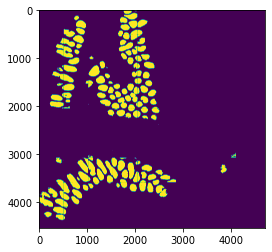

Shaped series: axes do not match shape


testing HandE_B005_CL_b_RGB_bottomleft


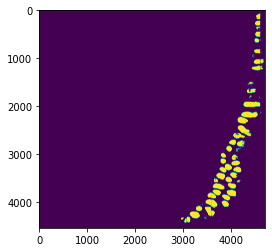

dice scores [0.9074720082560629, 0.7623446336538605]
Average test dice score is  0.8349083209549617


In [14]:
prediction(model,test_data_path,df_test,False)